# Incendio Forestal (Michelle Bojórquez Gómez | A00833416)

Esta simulación de incendio forestal trata de emular un entorno natural de un bosque. Tristemente este bosque va a presentar un fuego inicial el cual se irá propagando y consumirá todo el bosque. Lo que se busca con este trabajo es generar conciencia de lo que podría pasar en un escenario real y dimensionar los daños ecológicos que podría ocasionar este desastre.

## Reglas

El entorno del **Incendio Forestal** consta de una cuadrícula bidimensional de árboles cuadrados, cada una de ellos se encuentra con uno de tres posibles estados: **vivo (verde), incendiado (rojo) o quemado (negro)**. Cada árbol **interactúa con cuatro vecinos**, que son las celdas adyacentes horizontales y verticales, no diagonales. En cada paso de tiempo, las siguientes transiciones ocurren:

1. Cualquier árbol que tenga dos o más vecinos revive.
2. El fuego solo solo se puede esparcir en forma de cruz (horizontal y vertical)

**El patrón inicial** constituye la semilla del sistema e **incendia de manera random algunos árboles del entorno**. La primera generación es creada al aplicar las reglas anteriores de manera simultanea a cualquier celda en la semilla y el momento discreto en el cual esto pasa es a veces llamado turno. Cada generación es una función pura de la anterior. Las reglas se aplican de forma repetida para crear nuevas generaciones.

In [ ]:
!python3 -m pip install mesa

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [ ]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultánea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar cómo evoluciona el autómata celular.
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores numéricos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
import random

## Crear el modelo

Antes que nada el presente modelo se encuentra basado en el [tutorial introductorio](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html). Se modificó para que funcionara con el presente problema pero en esencia es lo mismo.

In [ ]:
class ForestFireAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = "tree"  # Initial state is a tree
        self.next_state = "tree"  # Next state, initially set to tree

    def step(self):
        neighbors = self.model.grid.get_neighbors(
            self.pos,
            moore=False,
            include_center=False
        )
        burning_neighbors = sum(1 for neighbor in neighbors if neighbor.state == "fire")

        if self.state == "tree":
            if burning_neighbors >= 1:
                self.next_state = "fire"
        elif self.state == "fire":
            self.next_state = "burned"

    def advance(self):
        self.state = self.next_state

class ForestFireModel(Model):
    def __init__(self, width, height, density):
        self.width = width
        self.height = height
        self.density = density
        self.grid = SingleGrid(self.width, self.height, True)
        self.schedule = SimultaneousActivation(self)

        # Create a 2D array to store agent information
        self.agent_grid = np.empty((self.width, self.height), dtype=object)

        # Create agents (trees) based on the density
        self.create_agents()

        self.datacollector = DataCollector(
            model_reporters={
                "Total Trees": lambda m: np.sum(m.get_grid(m) == 0),
                "Total Fires": lambda m: np.sum(m.get_grid(m) == 1),
                "Total Burned Trees": lambda m: np.sum(m.get_grid(m) == 2)
            },
            agent_reporters={
                "x": lambda a: a.pos[0],
                "y": lambda a: a.pos[1],
                "state": lambda a: a.state
            }
        )

    def create_agents(self):
        for (content, pos) in self.grid.coord_iter():
            a = ForestFireAgent(pos, self)
            a.state = "tree"
            if random.random() < self.density:
                a.state = "fire"  # Ignite some trees initially
            self.grid.place_agent(a, pos)
            self.schedule.add(a)

            # Store agent in the agent_grid
            x, y = pos
            self.agent_grid[x][y] = a

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def get_grid(self, model):
        grid = np.zeros((self.grid.width, self.grid.height), dtype=int)
        for cell in self.grid.coord_iter():
            content, pos = cell
            if content is not None:
                x, y = pos
                if content.state == "tree":
                    grid[x][y] = 0  # Tree is represented as 0
                elif content.state == "fire":
                    grid[x][y] = 1  # Fire is represented as 1
                else:
                    grid[x][y] = 2  # Burned tree is represented as 2
        return grid

# Ejecución del modelo
A continuación corremos el modelo

In [ ]:
# Parámetros del modelo
GRID_SIZE = 100
DENSITY = 0.001
NUM_GENERATIONS = 50

# Almacena el tiempo de ejecución
start_time = time.time()

# Almacena informacion de los agentes
all_agents_info = []

# Crear el forest fire model
model = ForestFireModel(GRID_SIZE, GRID_SIZE, DENSITY)
for i in range(NUM_GENERATIONS):
    model.step()
    # Get information for all agents at this step
    step_agents_info = []
    for agent in model.schedule.agents:
        x, y = agent.pos
        state = agent.state
        step_agents_info.append((x, y, state))  # Store as a tuple

    all_agents_info.append(step_agents_info)

final_time = time.time()

print('Execution time:', str(datetime.timedelta(seconds=(final_time - start_time))))

Execution time: 0:00:05.808422


Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [ ]:
all_grids = model.datacollector.get_model_vars_dataframe()

all_agents_df = pd.DataFrame({"all_agents_info": all_agents_info})

# Concatenamos DataFrame con all_grids
all_grids = pd.concat([all_grids, all_agents_df], axis=1)

Graficamos la información usando `matplotlib`

In [ ]:
all_grids

Total Trees  Total Fires  Total Burned Trees  \
0          9987           13                   0   
1          9935           52                  13   
2          9831          104                  65   
3          9675          156                 169   
4          9467          208                 325   
5          9207          260                 533   
6          8905          302                 793   
7          8563          342                1095   
8          8180          383                1437   
9          7758          422                1820   
10         7299          459                2242   
11         6811          488                2701   
12         6304          507                3189   
13         5826          478                3696   
14         5369          457                4174   
15         4930          439                4631   
16         4492          438                5070   
17         4104          388                5508   
18         3730          374                5896   
19         3360          370                6270   
20         3026          334                6640   
21         2733          293                6974   
22         2468          265                7267   
23         2253          215                7532   
24         2046          207                7747   
25         1849          197                7954   
26         1693          156                8151   
27         1542          151                8307   
28         1395          147                8458   
29         1252          143                8605   
30         1113          139                8748   
31          978          135                8887   
32          851          127                9022   
33          731          120                9149   
34          615          116                9269   
35          503          112                9385   
36          395          108                9497   
37          324           71                9605   
38          271           53                9676   
39          222           49                9729   
40          177           45                9778   
41          136           41                9823   
42           99           37                9864   
43           66           33                9901   
44           45           21                9934   
45           28           17                9955   
46           15           13                9972   
47            6            9                9985   
48            1            5                9994   
49            0            1                9999   

                                      all_agents_info  
0   [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
1   [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
2   [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
3   [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
4   [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
5   [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
6   [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
7   [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
8   [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
9   [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
10  [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
11  [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
12  [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
13  [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
14  [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
15  [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
16  [(0, 0, tree), (0, 1, tree), (0, 2, tree), (0,...  
17  [(0, 0, tree), (0, 1, tree), (0, 2, fire), (0,...  
18  [(0, 0, tree), (0, 1, fire), (0, 2, burned), (...  
19  [(0, 0, fire), (0, 1, burned), (0, 2, burned),...  
20  [(0, 0, burned), (0, 1, burned), (0, 2, burned...  
21  [(0, 0, burned), (0, 1, burned), (0, 2, burned...  
22  [(0, 0, burned), (0, 1, burned), (0, 2, burned...  
23  [(0

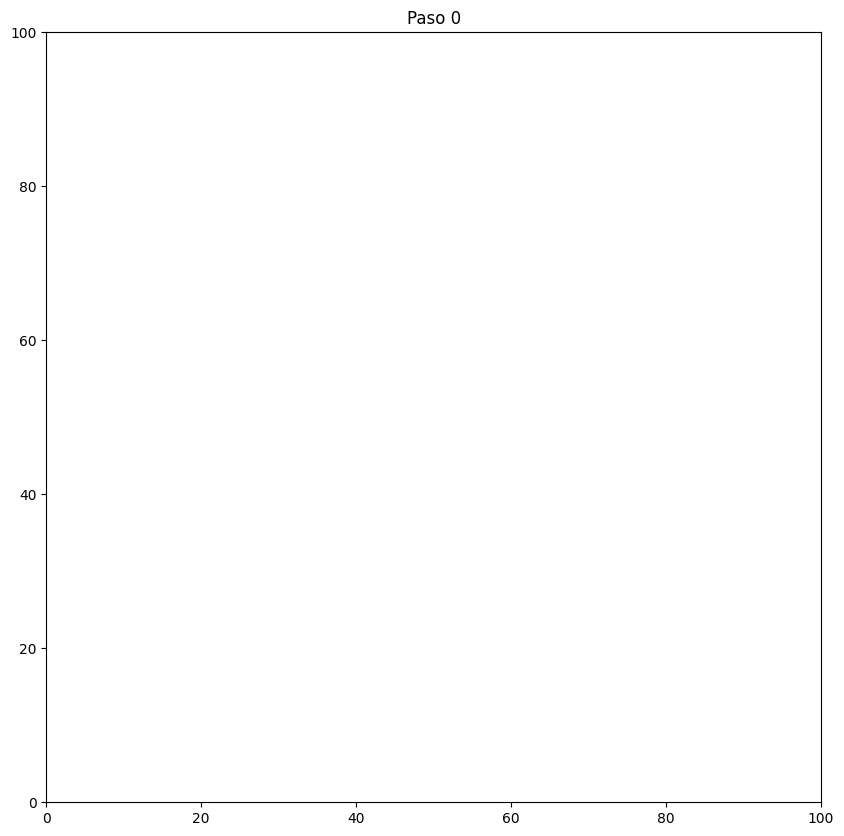

In [ ]:
# Define custom colormaps for tree, fire, and burned states
cmap = ListedColormap(['green', 'red', 'black'])

# Create a function to update the animation at each frame
def update(frame):
    ax.clear()
    ax.set_title(f"Paso {frame}")
    grid_data = all_grids["all_agents_info"][frame]

    # Extract x, y, and state from the grid_data
    x, y, state = zip(*grid_data)

    # Map states to colors
    colors = [0 if s == "tree" else 1 if s == "fire" else 2 for s in state]

    # Create a scatter plot of the grid
    sc = ax.scatter(x, y, c=colors, cmap=cmap, s=100)

    return sc

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Paso 0")

# Set the axis limits based on the grid size
ax.set_xlim(0, GRID_SIZE)
ax.set_ylim(0, GRID_SIZE)

# Create the animation
ani = FuncAnimation(fig, update, frames=num_filas, blit=False)
plt.show()

In [ ]:
ani

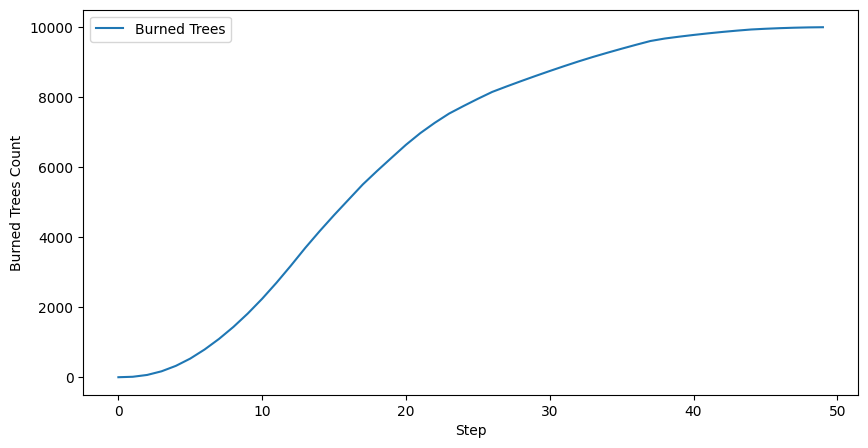

In [ ]:
# Obtén los datos recopilados del modelo
data = all_grids

# Calcula el recuento de árboles quemados en cada paso
burned_trees_count = data["Total Burned Trees"]

# Crea una gráfica para mostrar el recuento de árboles quemados
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
axs.set_xlabel("Step")
axs.set_ylabel("Burned Trees Count")
axs.plot(burned_trees_count, label="Burned Trees")
axs.legend(loc="upper left")
plt.show()